<a href="https://colab.research.google.com/github/BrunoFelalaga/diffusion_model_for_scanned_pdf_denoising/blob/main/ddm_implicit_bb_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

diffusion_nbs = '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1'
%cd $diffusion_nbs


Mounted at /content/gdrive
/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1


In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import layers
from keras import ops

In [4]:
# data
dataset_name = "problematic_pdf_imgs" #"oxford_flowers102"
dataset_repetitions = 5
num_epochs = 50  # train for at least 50 epochs for good results
image_size = 64

# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

# for loading saved model or training
LOAD_SAVED = False

# RGB or GRAY
GRAY = True

In [5]:
import tensorflow as tf
import os
import numpy as np
from glob import glob

def load_files(image_dir, split_ratio=0.8):
    # Get all image files from directory
    image_patterns = ['*.jpg', '*.jpeg', '*.png']  # Define supported image patterns
    image_files = []
    for pattern in image_patterns:
        image_files.extend(glob(os.path.join(image_dir, pattern)))  # Collect all image paths

    np.random.shuffle(image_files)  # Shuffle file order randomly
    split_idx = int(len(image_files) * split_ratio)  # Calculate split index for train/val

    return image_files[:split_idx], image_files[split_idx:]  # Return split file lists

def preprocess_image(image_path, image_size, is_gray=False):
    # Load and decode image
    image = tf.io.read_file(image_path)  # Read image file from disk
    image = tf.image.decode_image(image, channels=3, expand_animations=False)  # Decode to tensor with 3 channels
    if is_gray == True:
      image = tf.image.rgb_to_grayscale(image)  # Convert RGB to Grayscale (1 channel) XXXXXXX----------------------------------BW
    image = tf.cast(image, tf.float32)  # Convert to float32 for processing

    # Center crop image
    height = tf.shape(image)[0]  # Get image height
    width = tf.shape(image)[1]   # Get image width
    crop_size = tf.minimum(height, width)  # Determine smaller dimension for cropping

    image = tf.image.crop_to_bounding_box(
        image,
        (height - crop_size) // 2,  # Calculate top offset for center crop
        (width - crop_size) // 2,   # Calculate left offset for center crop
        crop_size,                  # Set crop height
        crop_size,                  # Set crop width
    )

    # Resize and normalize
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)  # Resize image with antialiasing
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)  # Normalize pixel values to [0, 1]

def create_dataset(file_list, batch_size, image_size, repeat=1, is_gray=False):
    # Create and configure dataset pipeline
    return (
        tf.data.Dataset.from_tensor_slices(file_list)  # Create dataset from file paths
        .map(lambda x: preprocess_image(x, image_size, is_gray=is_gray),
             num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing in parallel
        .cache()  # Cache processed images in memory
        .repeat(repeat)  # Repeat dataset for multiple epochs
        .shuffle(10 * batch_size)  # Shuffle with buffer of 10x batch_size
        .batch(batch_size, drop_remainder=True)  # Create batches, dropping incomplete ones
        .prefetch(tf.data.AUTOTUNE)  # Prefetch next batch while processing current one
    )

def load_custom_dataset(image_dir, batch_size=64, image_size=64, split_ratio=0.8, repeat=1, is_gray=False):
    # Split files into train and validation sets
    train_files, val_files = load_files(image_dir, split_ratio)  # Get train/val file lists

    # Create train and validation datasets
    train_dataset = create_dataset(train_files, batch_size, image_size, repeat, is_gray)  # Prepare training dataset
    val_dataset = create_dataset(val_files, batch_size, image_size, repeat, is_gray)  # Prepare validation dataset

    return train_dataset, val_dataset



In [6]:
# Configuration parameters
image_dir = "/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/prob_imgs"  # Image directory path
batch_size = 64  # Number of images per batch
image_size = 64  # Target image dimensions
repeat = 5  # Number of dataset repetitions
# print(GRAY)
# Load and prepare datasets
train_dataset, val_dataset = load_custom_dataset( image_dir=image_dir,
                                                  batch_size=batch_size,
                                                  image_size=image_size,
                                                  split_ratio=0.8,  # 80% for training, 20% for validation
                                                  repeat=repeat, is_gray=GRAY)  # Repeat dataset for training

for batch in train_dataset.take(1):
    print("Batch shape:", batch.shape)  # Should output (batch_size, image_size, image_size, 1)


Batch shape: (64, 64, 64, 1)


In [7]:

@keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, is_gray=False, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # Determine input channels dynamically
        input_channels = 1 if is_gray else 3

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, input_channels),
                    weights=None if is_gray else "imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = ops.cast(ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel( generated_features, generated_features)
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = real_features.shape[0]
        batch_size_f = ops.cast(batch_size, dtype="float32")
        mean_kernel_real = ops.sum(kernel_real * (1.0 - ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = ops.sum(
            kernel_generated * (1.0 - ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = ops.mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


In [8]:
def get_network(image_size, widths, block_depth, is_gray=False):
    # Determine the number of input and output channels
    input_channels = 1 if is_gray else 3
    output_channels = 1 if is_gray else 3

    # Define inputs
    noisy_images = keras.Input(shape=(image_size, image_size, input_channels))
    noise_variances = keras.Input(shape=(1, 1, 1))

    # Sinusoidal embedding for noise variances
    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    # Initial convolution
    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])
    skips = []

    # Downsampling path
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    # Bottleneck (middle block)
    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    # Upsampling path
    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    # Final convolution to match output channels
    x = layers.Conv2D(output_channels, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")


In [9]:
@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    # Define minimum frequency for embeddings
    embedding_min_frequency = 1.0

    # Generate logarithmically spaced frequencies
    frequencies = ops.exp(ops.linspace( ops.log( embedding_min_frequency),
                                        ops.log(embedding_max_frequency),
                                        embedding_dims // 2,))

    # Compute angular speeds for sinusoidal functions
    angular_speeds = ops.cast(2.0 * math.pi * frequencies, "float32")

    # Concatenate sine and cosine embeddings
    embeddings = ops.concatenate([ops.sin(angular_speeds * x),
                                  ops.cos(angular_speeds * x)], axis=3)
    return embeddings


def ResidualBlock(width):
    # Define a residual block for feature learning
    def apply(x):
        input_width = x.shape[3]  # Get input tensor width (number of channels)

        # Match input width to target width with a 1x1 convolution if needed
        if input_width == width:
            residual = x  # No adjustment needed
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)  # Adjust channels

        # Apply batch normalization (no scaling or centering)
        x = layers.BatchNormalization(center=False, scale=False)(x)

        # Apply two 3x3 convolutions with activation for feature extraction
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)

        # Add the residual connection
        x = layers.Add()([x, residual])
        return x
    return apply


def DownBlock(width, block_depth):
    # Define a downsampling block with residual connections
    def apply(x):
        x, skips = x  # Separate input tensor and skip connections

        # Apply multiple residual blocks
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)  # Extract features
            skips.append(x)  # Save skip connection

        # Downsample features using average pooling
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x
    return apply


def UpBlock(width, block_depth):
    # Define an upsampling block with skip connections
    def apply(x):
        x, skips = x  # Separate input tensor and skip connections

        # Upsample the tensor to double its spatial size
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)

        # Apply multiple residual blocks with skip connections
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])  # Concatenate skip connection
            x = ResidualBlock(width)(x)  # Extract features
        return x
    return apply


In [10]:
def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
        end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")
        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
        # angles -> signal and noise rates
        signal_rates = ops.cos(diffusion_angles)
        noise_rates = ops.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1
        return noise_rates, signal_rates

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import register_keras_serializable

# @keras.saving.register_keras_serializable()
@register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth, is_gray=False):
        super().__init__()

        self.image_size = image_size
        self.is_gray = is_gray  # Flag to indicate grayscale images

        # Normalization layer to standardize inputs
        self.normalizer = layers.Normalization()

        # Create the main network with dynamic input channels
        self.network = get_network(
            image_size=image_size,
            widths=widths,
            block_depth=block_depth,
            is_gray=self.is_gray  # Pass the grayscale flag
        )

        # Create an exponential moving average (EMA) of the network
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        # Trackers for noise and image loss
        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

        # Initialize KID metric with grayscale flag
        self.kid = KID(name="kid", is_gray=self.is_gray)

    @property
    def metrics(self):
        # Return the list of metrics for tracking
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # Convert pixel values back to [0, 1] range from normalized
        images = self.normalizer.mean + images * self.normalizer.variance ** 0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # Define the start and end angles for diffusion
        start_angle = tf.cast(tf.acos(max_signal_rate), dtype="float32")
        end_angle = tf.cast(tf.acos(min_signal_rate), dtype="float32")

        # Compute diffusion angles for given times
        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # Calculate signal and noise rates from angles
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # Note: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # Select the appropriate network (EMA network during inference)
        network = self.network if training else self.ema_network

        # Predict noise component
        pred_noises = network([noisy_images, noise_rates ** 2], training=training)
        # Calculate the predicted clean image
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # Initialize variables for reverse diffusion process
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        next_noisy_images = initial_noise  # Start with initial noise

        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # Compute current diffusion times
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            # Get noise and signal rates
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

            # Denoise the images
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )

            # Compute next diffusion times
            next_diffusion_times = diffusion_times - step_size
            # Get next noise and signal rates
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)

            # Prepare noisy images for next step
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )

        return pred_images  # Return the final denoised images

    def generate(self, num_images, diffusion_steps):
        # Determine number of channels based on grayscale flag
        input_channels = 1 if self.is_gray else 3

        # Generate initial random noise
        initial_noise = tf.random.normal(
            shape=(num_images, self.image_size, self.image_size, input_channels)
        )

        # Perform reverse diffusion to generate images
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        # Denormalize images back to [0, 1] range
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # Determine number of channels
        input_channels = 1 if self.is_gray else 3

        # Normalize input images
        images = self.normalizer(images, training=True)
        # Generate random noise
        noises = tf.random.normal(
            shape=(tf.shape(images)[0], self.image_size, self.image_size, input_channels)
        )

        # Sample random diffusion times uniformly between 0 and 1
        diffusion_times = tf.random.uniform(
            shape=(tf.shape(images)[0], 1, 1, 1), minval=0.0, maxval=1.0
        )
        # Compute noise and signal rates
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # Create noisy images by mixing images with noise
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # Predict noise and images from noisy inputs
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            # Calculate losses
            noise_loss = self.loss(noises, pred_noises)  # Loss on noise prediction
            image_loss = self.loss(images, pred_images)  # Loss on image reconstruction

        # Compute gradients and apply optimizer
        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # Update loss metrics
        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # Update EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # Return metrics (excluding KID for efficiency)
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # Determine number of channels
        input_channels = 1 if self.is_gray else 3

        # Normalize input images
        images = self.normalizer(images, training=False)
        # Generate random noise
        noises = tf.random.normal(
            shape=(tf.shape(images)[0], self.image_size, self.image_size, input_channels)
        )

        # Sample random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(tf.shape(images)[0], 1, 1, 1), minval=0.0, maxval=1.0
        )
        # Compute noise and signal rates
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # Create noisy images
        noisy_images = signal_rates * images + noise_rates * noises

        # Predict noise and images without training
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        # Calculate losses
        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        # Update loss metrics
        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # Denormalize images for KID computation
        images = self.denormalize(images)
        # Generate new images for comparison
        generated_images = self.generate(
            num_images=tf.shape(images)[0], diffusion_steps=kid_diffusion_steps
        )
        # Update KID metric
        self.kid.update_state(images, generated_images)

        # Return all metrics
        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # Generate images using the model
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for index, image in enumerate(generated_images):
            plt.subplot(num_rows, num_cols, index + 1)
            if self.is_gray:
                # Use tf.squeeze to remove the channel dimension
                image = tf.squeeze(image, axis=-1)
                # Convert tensor to NumPy array for plotting
                image = image.numpy()
                # If grayscale, remove channel dimension and use grayscale colormap
                plt.imshow(image.squeeze(), cmap='gray')
            else:
                plt.imshow(image)
            plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()


In [ ]:
# ~45mins for A100 on 50 epochs with early stopping

if LOAD_SAVED:
  raise SystemExit("Skip model training and load pre-trained model")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import EarlyStopping


# create and compile the model
model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)

# for below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile( optimizer=keras.optimizers.AdamW(learning_rate=learning_rate,
                                                weight_decay=weight_decay),
                loss=keras.losses.MeanAbsoluteError()) # pixelwise mean absolute error is used as loss

# Early Stopping bb
# Define Early Stopping
early_stopping_callback = EarlyStopping(  monitor="val_kid",  # Metric to monitor (change if needed)
                                          patience=10,        # Number of epochs with no improvement before stopping
                                          mode="min",         # Direction: "min" for validation loss
                                          restore_best_weights=True,  # Restore weights from the best epoch
                                          verbose=1 )           # Print when stopping occurs


# save the best model based on the validation KID metric
model_num = len(os.listdir(f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models'))
checkpoint_path = f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models/ddim_implicit_bb_v{model_num}.weights.h5'

checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      monitor="val_kid",
                                                      mode="min",
                                                      save_best_only=True,)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# run training and plot generated images periodically
model.fit(  train_dataset,
            epochs= 1, #200, # num_epochs = 50, also stops at 50 with early stopping
            validation_data=val_dataset,
            callbacks=[ keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
                        checkpoint_callback, early_stopping_callback, ], )

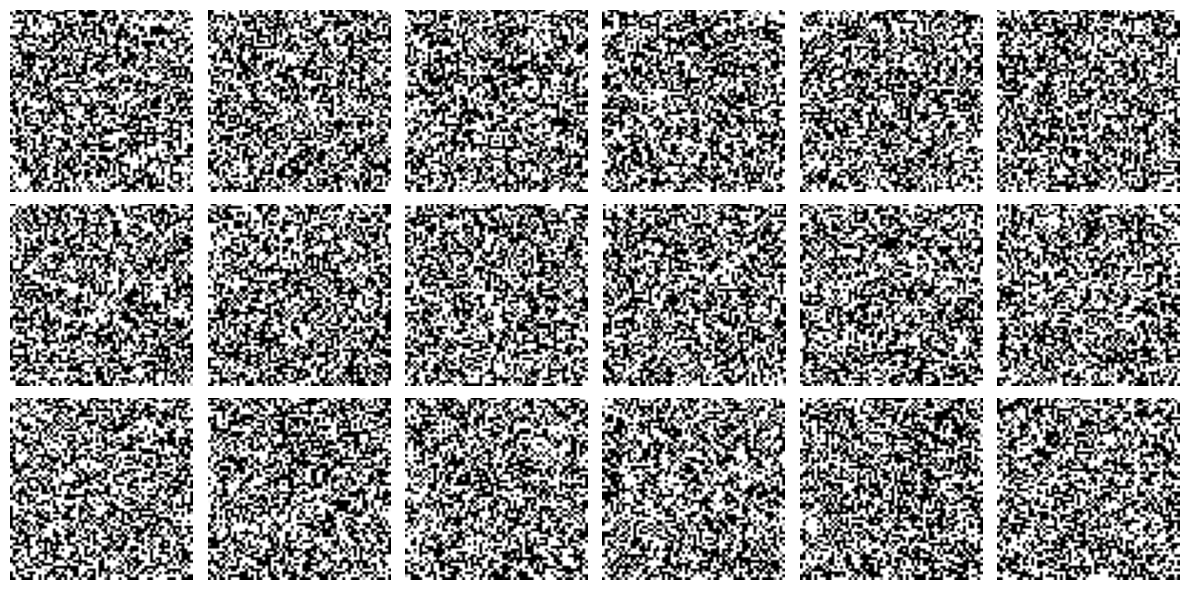

In [12]:
LOAD_SAVED = True
# if not LOAD_SAVED:
#   raise SystemExit("Skip model training and load pre-trained model") #, ignore_errors=True)

# load the best model and generate images
checkpoint_path = f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models/ddim_implicit_bb_v3.weights.h5'

model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)
model.normalizer.adapt(train_dataset) # adapt the normalizer before using the pre-trained model
model.load_weights(checkpoint_path)
model.plot_images()